# Convolutional Autoencoder

Reflections:
The following model uses conv2d for down-sampling images, and uses conv2d_transpose for up-sampling images. Also, the images are rescaled by subtracting against the mean and dividing by the standard deviation. The results are pretty decent, except for a **checkered** output on the generated images. I think this (the checkered outputs) are a well-documented artifact of applying conv2d_transpose with overlapping strides (and documented here: https://distill.pub/2016/deconv-checkerboard/)

In a separate file, I'll try to 
- a) try get rid of the checkerboard artifact (would that help ?)
- b) use k.nearest_neighbor_search instead of conv2d_transpose ?
- c) do some validation testing (i.e. reserve about 20% of the images for validation to see the quality of generated images)

One new thing for me is the process of rescaling pixels values of images (subtract mean and divide by stddev). The plotted images are exactly similar. What happens when we do such a thing?

Footnote:

Pretty sure I haven't correctly used the batch_normalization layer properly in this notebook. If I have time, I might get back to it, but the correct usage will also be demo-ed in the second attempt file. Things that need to be done for correct batch_normalization.
  - remove bias and activation functions
  - put a batch_norm layer
  - run it via relu or prelu
  - define an optimizer under a tf.control_dependencies block

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
inputs_ = tf.placeholder(tf.float32, (None, 224, 224, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 224, 224, 1), name='targets')

In [3]:
xavier_wts = tf.contrib.layers.xavier_initializer()

In [4]:
def getEncoder(images, is_training = True, reuse=False):
    ### Encoder
    alpha = 0.5    
    with tf.variable_scope("encoder",reuse=reuse):

        # input: 224 * 224 * num_channels    
        x = tf.layers.conv2d(inputs=inputs_, filters=8, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)

        #print(x.shape.as_list())

        # input: 112 * 112 * 8    
        x = tf.layers.conv2d(inputs=x, filters=16, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 56 * 56 * 16
        x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 28 * 28 * 32
        x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 14 * 14 * 64
        x = tf.layers.conv2d(inputs=x, filters=128, kernel_size=5, strides=2, activation=None, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_training)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # Output: 7 * 7 * 128

        # Guess this will be the bottleneck for our encoder layer
        x = tf.reshape(tensor=x, shape=(-1, 7*7*128))
        #print(x.shape.as_list())

        output_encoder = tf.sigmoid(x)
        return output_encoder

In [5]:
enc_output = getEncoder(inputs_)

In [6]:
def getDecoder(z, is_train=True, reuse=False):
    alpha = 0.5

    with tf.variable_scope("decoder", reuse=reuse):
        
        # input: 7 * 7 * 128 long 1-D vector
        x = tf.reshape(z, shape=(-1, 7, 7, 128))

        # apply batch_normalization and relu activation
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())

        # input: 7 * 7 * 128
        x = tf.layers.conv2d_transpose(inputs=x, filters=64, activation=None, kernel_size=5, strides=2, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x.shape.as_list())
        
        # input: 14 * 14 * 64 
        x = tf.layers.conv2d_transpose(inputs=x, filters=32, activation=None, kernel_size=5, strides=2, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)        
        #print(x.shape.as_list())

        # input: 28 * 28 * 32 
        x = tf.layers.conv2d_transpose(inputs=x, filters=16, activation=None, kernel_size=5, strides=2, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)        
        #print(x.shape.as_list())
        
        # input: 56 * 56 * 16 
        x = tf.layers.conv2d_transpose(inputs=x, filters=8, activation=None, kernel_size=5, strides=2, padding='same', kernel_initializer=xavier_wts)
        x = tf.layers.batch_normalization(inputs=x, training=is_train)
        x = tf.maximum(alpha * x, x)        
        #print(x.shape.as_list())
        
        # input: 128 * 128 * 8 
        x = tf.layers.conv2d_transpose(inputs=x, filters=1, activation=None, kernel_size=5, strides=2, padding='same', kernel_initializer=xavier_wts)
        #print(x.shape.as_list())        
        # output: 224 * 224 * 1

        # rescale output using tanh
        output_decoder = tf.tanh(x)
        
        return output_decoder


In [7]:
dec_output = getDecoder(enc_output)

## Define model loss and optimizer

In [8]:
loss = tf.reduce_mean(tf.squared_difference(targets_, dec_output))

In [9]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

## Ingest Images

In [10]:
all_images = np.load('Product_Images/all_images_raw_grayscale.npy')
mean_imgs = np.mean(all_images)
stddev = np.std(all_images)

# rescale image so that pixels dont have the range from 0 - 255
rescaled_images = (all_images - mean_imgs)/stddev

# reshape images so that it can be fed to con2d methods
in_images = np.reshape(rescaled_images, newshape=(-1,224,224,1))

In [11]:
def image_generator(images, batch_size):
    start_index = 0    
    while start_index < len(images):
        end_index = start_index + batch_size
        yield images[start_index:end_index,:,:,:]
        start_index = end_index

batch_size = 128

In [30]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [22]:
start_epochs = 0
end_epochs = 30

In [28]:
train_images = in_images[0:2922]
valid_images = in_images[2923:2953]

In [29]:
print(train_images.shape)
print(valid_images.shape)

(2922, 224, 224, 1)
(30, 224, 224, 1)


In [31]:
for epoch_n in range(start_epochs, end_epochs):
    print("epochs: "+str(epoch_n))
    counter = 0
    for img in image_generator(train_images, batch_size):
        counter +=1
        _ , enc_out, dec_out, train_loss = sess.run([opt, enc_output, dec_output, loss], feed_dict={inputs_:img, targets_:img})        
  
        if(counter%10==0):
            print("  train_loss: "+str(train_loss))


epochs: 0
  train_loss: 1.01335
  train_loss: 0.873276
epochs: 1
  train_loss: 0.766197
  train_loss: 0.677905
epochs: 2
  train_loss: 0.5963
  train_loss: 0.544792
epochs: 3
  train_loss: 0.498032
  train_loss: 0.469444
epochs: 4
  train_loss: 0.438822
  train_loss: 0.421538
epochs: 5
  train_loss: 0.398638
  train_loss: 0.387438
epochs: 6
  train_loss: 0.369093
  train_loss: 0.361481
epochs: 7
  train_loss: 0.346051
  train_loss: 0.341257
epochs: 8
  train_loss: 0.327741
  train_loss: 0.324916
epochs: 9
  train_loss: 0.312876
  train_loss: 0.311717
epochs: 10
  train_loss: 0.300777
  train_loss: 0.300945
epochs: 11
  train_loss: 0.29088
  train_loss: 0.292077
epochs: 12
  train_loss: 0.282697
  train_loss: 0.284646
epochs: 13
  train_loss: 0.275839
  train_loss: 0.278343
epochs: 14
  train_loss: 0.270004
  train_loss: 0.272979
epochs: 15
  train_loss: 0.264973
  train_loss: 0.268408
epochs: 16
  train_loss: 0.260604
  train_loss: 0.264472
epochs: 17
  train_loss: 0.256774
  train_los

## Print some images for visual validation

### Trained images

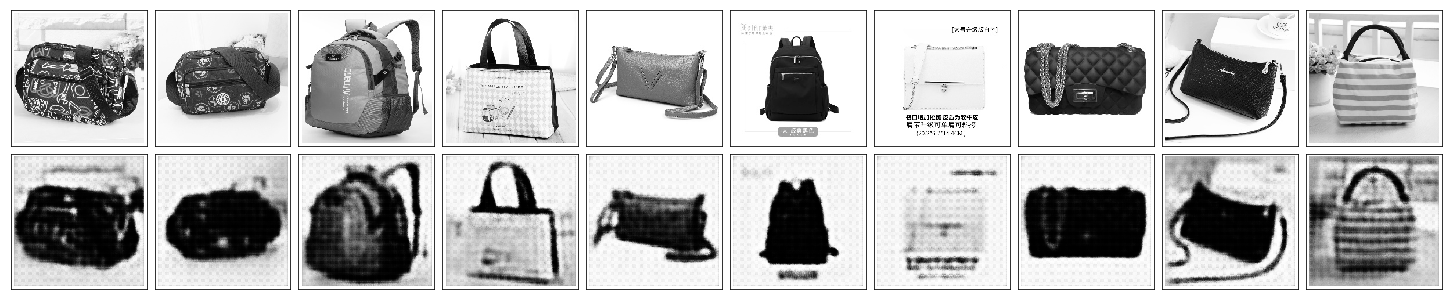

In [32]:
show_imgs = train_images[30:40]

# draw the image
# make plots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

reconstructed = sess.run(dec_output, feed_dict={inputs_: show_imgs})
for images, row in zip([show_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((224, 224)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

### Validation images

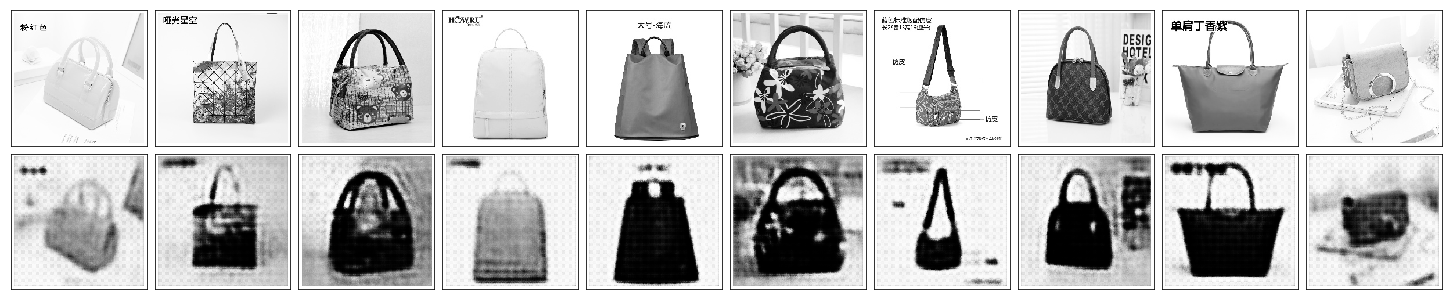

In [34]:
show_imgs = valid_images[10:20]

# draw the image
# make plots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

reconstructed = sess.run(dec_output, feed_dict={inputs_: show_imgs})
for images, row in zip([show_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((224, 224)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)